<h1>A Python 3.7 Intoduction to FIR Filtering</h1>
<h5>By: Erica Sawczynec</h5>

<p>The goal of this tutorial is to walk you through how I simulate the results of 3 bit FIR filtered data in order to familiarize you with our data set, FIR filtering in Python 3.7, how we can estimate the pulse height and time after filtering, and finally, reproduce the filtering results I found.</p>

<p>Let's start with a little bit about our data set.  The data I have provided to you was taken using two SensL SiPM's read out to two different channels on a Infinium V-Series oscilloscope. Each SiPM fed a ~30 V from a Mastech DC power supply.  For this particular dataset the events are produced from a CS-137 source placed closely to the two SiPMs. Each SiPM is attached to a different channel, in the dataset files you will notice they are labeled Channel 3 and Channel 4.  Each channel has the same sampling rate and voltage trigger on the pulse. If you are not familiar with oscilloscopes, triggers are set in either voltage or time so the scope knows when to record events.  In our case, I programmed the scope so the incoming event voltage has to be above 3 mV on both channels otherwise the event will not be recorded.</p>

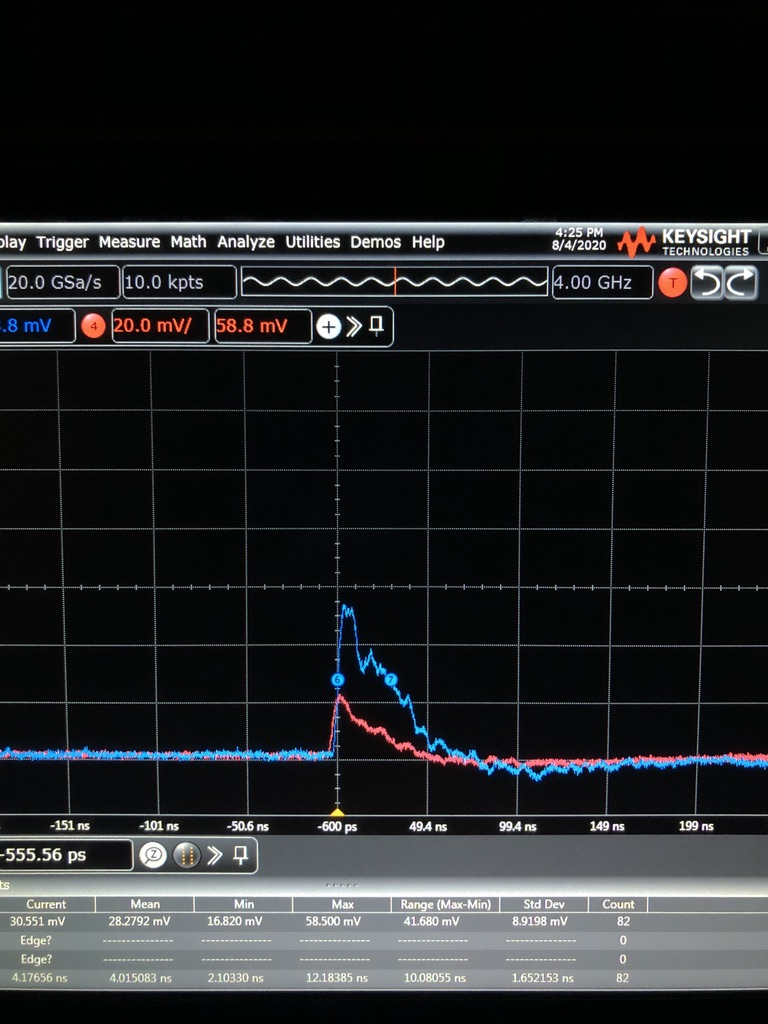

In [11]:
from IPython.display import Image, display
display(Image(filename='SiPM_example.jpeg', embed=True))

<div align="center">An example of a recorded SiPM event on the scope.  Channel 3 is shown in blue and Channel 4 is shown in red.  Notice the voltage difference between the two channels for the same event, this will be discussed later in this tutorial.</div>

In [ ]:
#first we import all the packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy import stats
from scipy.stats import norm
from scipy import interpolate
import numpy.polynomial.polynomial as poly
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import fsolve

<p>After importing all the packages we want to use the first thing we want to do is read in the data files.  Each file has a column for time and voltage.  I prefer using pandas to turn each event into a dataframe and then store each dataframe in a dictionary where the number of the event is the key.  If you are not familiar with dictionaries in python <a href="https://www.w3schools.com/python/python_dictionaries.asp">this</a> is a short walk through of the basics.</p>

<p>In the following cell I have removed the code I would usually put into pd.read_csv() function.  <a href= "https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html">Here</a> is the documentation for that function. See if you can read in the events writing your own code here.  The two lines below the pd.read_csv() function should give you an indication of what the columns for each event should be named.  I multiply the times by 10**9 to have them in ns and I multiply our Voltages by 10**3 to have them in mV.  I have also removed the number of events to iterate through so you can select that.  Remember that reading in all the events will take time, so it might be beneficial to iterate through the first 10 events to see if you code works.  Here are some other links that might help: <a href = "https://realpython.com/python-f-strings/">formatting f strings</a>, <a href = "https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html">pd.Dataframe</a>.</p>

In [ ]:
#an ordered dictionary is a little different from a normal dictionary, but they have the same function
#it's easy to seperate the data into each channel and save it that way
data_ch3, data_ch4 = (OrderedDict() in range(2))

#I prefer starting my keys with 0 instead of 1 (to follow python indexing rules)
a = 0
#now we loop through all the events in the dataset
for iteration in range(1, ):
    #we use if, elif, and else statements because there are varying numbers of 0 in front of each number in the dataset
    if iteration < 10:
        #read in the event from a channel 3 file
        data_ch3[str(a)] = pd.read_csv()
        #multiply const so time is in ns
        data_ch3[str(a)].times = data_ch3[str(a)].times * 10**9 
        #multiply const so voltage is in ns
        data_ch3[str(a)].Voltages = data_ch3[str(a)].Voltages * 10**3
        #increment a for next event
        
        #read in the event from a channel 4 file
        data_ch4[str(a)] = pd.read_csv()
        #multiply const so time is in ns
        data_ch4[str(a)].times = data_ch4[str(a)].times * 10**9 
        #multiply const so voltage is in ns
        data_ch4[str(a)].Voltages = data_ch4[str(a)].Voltages * 10**3
        #increment a for next event
        
        a+=1
    elif iteration >= 10 and iteration <= 99:
        #read in the event from a channel 3 file
        data_ch3[str(a)] = pd.read_csv()
        data_ch3[str(a)].times = data_ch3[str(a)].times * 10**9
        data_ch3[str(a)].Voltages = data_ch3[str(a)].Voltages * 10**3
        
        #read in the event from a channel 4 file
        data_ch4[str(a)] = pd.read_csv()
        data_ch4[str(a)].times = data_ch4[str(a)].times * 10**9 
        data_ch4[str(a)].Voltages = data_ch4[str(a)].Voltages * 10**3
        
        a+=1
    elif iteration > 99 and iteration <=999:
        #read in the event from a channel 3 file
        data_ch3[str(a)] = pd.read_csv()
        data_ch3[str(a)].times = data_ch3[str(a)].times * 10**9
        data_ch3[str(a)].Voltages = data_ch3[str(a)].Voltages * 10**3
        
        #read in the event from a channel 4 file
        data_ch4[str(a)] = pd.read_csv()
        data_ch4[str(a)].times = data_ch4[str(a)].times * 10**9 
        data_ch4[str(a)].Voltages = data_ch4[str(a)].Voltages * 10**3
        
        a+=1
    else:
        #read in the event from a channel 3 file
        data_ch3[str(a)] = pd.read_csv()
        data_ch3[str(a)].times = data_ch3[str(a)].times * 10**9
        data_ch3[str(a)].Voltages = data_ch3[str(a)].Voltages * 10**3
        
        #read in the event from a channel 4 file
        data_ch4[str(a)] = pd.read_csv()
        data_ch4[str(a)].times = data_ch4[str(a)].times * 10**9 
        data_ch4[str(a)].Voltages = data_ch4[str(a)].Voltages * 10**3
        
        a+=1

<p>We are interested in some particular aspects of each event that we want to save for comparison to our recovery values later.  I show you how to quickly find the maximum voltage for each event, but I've deleted the code that finds the time that the maximum voltage occurs and where the information for each event is saved in one dataframe.  See if you can fill in this code.  Here are some links that may help: <a href = "https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html">indexing</a>, <a href = "https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html">pd.concat</a>, <a href = "https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html">pd.Dataframe</a>.</p>

In [ ]:
great_ch3, great_ch4 = (pd.DataFrame([]) for i in range(2))
great_index, great_times, great_peak = (pd.Series([]) for i in range(3))

for key, value in data_ch3.items():
    #find the maximum voltage of the event
    great_index[int(key)] = data_ch3[str(key)]['Voltages'].idxmax()
    #find the time the maximum voltage occurs

#save the maximum value of each event, the time the maximum value occurs, and 1/2 the maximum value in a data frame
#name each column max_vals, times, and half_max respectively
#named great_ch3


great_index, great_times, great_peak = (pd.Series([]) for i in range(3))

#find the max vals and times the max val occurs for each event
for key, value in data_ch4.items():
    #find the maximum voltage of the event
    great_index[int(key)] = data_ch4[str(key)]['Voltages'].idxmax()
    #find the time the maximum voltage occurs

#save the maximum value of each event, the time the maximum value occurs, and 1/2 the maximum value in a data frame
#name each column max_vals, times, and half_max respectively
#named great_ch4

<p>There are some events that we want to remove because they are gross outliers.</p>

In [ ]:
bad_index_ch4 = great_ch4[great_ch4['max_vals'] > 50].index

for index in bad_index_ch4:
    del data_ch4[str(index)]
    del data_ch3[str(index)]

great_ch3 = great_ch3.drop(great_ch3.index[[bad_index_ch4]])
great_ch4 = great_ch4.drop(great_ch4.index[[bad_index_ch4]])

<p>Unfortunatly the events off of the scope are not sampled at the rate we want them to be.  We are aiming for 1 GSPS sampling, which implies the difference between each sucessive time increment should be 1 ns.  This next cell takes one in every 40 timing points to mimic the sampling rate we want.  I've removed the code that takes one in every 40 points.  See if you can attain the sampling rate we want.  There is a commented print statement at the bottom of the cell that will help you check if there is 1 ns between successive time increments. Here is a link that might help: <a href = "https://numpy.org/doc/stable/reference/arrays.indexing.html">numpy indexing</a></p>

In [ ]:
#again we want to save each event dataframe in a dictionary
ori_ch3 = OrderedDict()
#here we initialize some arrays
ori_times, ori_vals = (pd.Series([]) for i in range(2))
temp = pd.DataFrame([])

#dict.items() is how you can iterate through the dictionary by key and the corresponding key's dataframe (values)
for key, values in data_ch3.items():
        
    #take one in every 40 values for time
    ori_times = 
    #take one in every 40 values for voltages
    ori_vals = 
    
    #make a df of times and voltages
    #save to the dictionary under that event name
    temp['times'] = ori_times
    temp['Voltages'] = ori_vals
    ori_ch3[key] = temp

    #recreate the df so theres no confusion
    temp = pd.DataFrame([])
    

ori_ch4 = OrderedDict()
ori_times, ori_vals = (pd.Series([]) for i in range(2))
temp = pd.DataFrame([])

for key, values in data_ch4.items():
    
    #take one in every 40 values for time
    ori_times = 
    #take one in every 40 values for voltages
    ori_vals = 

    #make the df of times and voltages
    #save to the dictionary under that event name
    temp['times'] = ori_times
    temp['Voltages'] = ori_vals
    ori_ch4[key] = temp

    #recreate the df so theres no confusion
    temp = pd.DataFrame([])
    
#let's check if we have the sampling rate we want
#print("The time between each timing increment is for Channel 3 is ()".format(ori_ch3[str(0)].times.iloc[1]-ori_ch3[str(0)].times.iloc[0]))
#print("The time between each timing increment is for Channel 4 is ()".format(ori_ch4[str(0)].times.iloc[1]-ori_ch4[str(0)].times.iloc[0]))

<p>Now that we have a dataset with the initial sampling rate we want.  We also want to create two other datasets with 2 GSPS (500 ps sampling) and 1 GSPS (1 ns sampling) for each channel.  This next cell is similar to the last cell in terms of code, so it should be straight forward what needs to be done here.  For the 2 GSPS dataset we want 5 ns between timing increments and for the 1 GSPS dataset we want 10 ns between timing increments.  As the cell above, there are print statements at the bottom of the cell you can use to check if you have the right sampling for each dictionary.</p>

In [ ]:
#initialize the new dictionaries
one_nano_ch3, five_hundred_pico_ch3 = (OrderedDict() for i in range(2))
#formality
one_nano_times, one_nano_vals, five_hundred_pico_times, five_hundred_pico_vals = (pd.Series([]) for i in range(4))
temp,temp1 = (pd.DataFrame([]) for i in range(2))

#now we can iterate through the events we just created and downsample from there
for key, values in ori_ch3.items():
        
    #keep the time vals consistant
    one_nano_times = 
    one_nano_vals = 

    #keep time vals constant
    five_hundred_pico_times = 
    five_hundred_pico_vals = 

    #make the df of times and voltages
    #save to the dictionary under that event name
    temp['times'] = one_nano_times
    temp['Voltages'] = one_nano_vals
    one_nano_ch3[str(key)] = temp
    temp1['times'] = five_hundred_pico_times
    temp1['Voltages'] = five_hundred_pico_vals
    five_hundred_pico_ch3[str(key)] = temp1

    #recreate the df so theres no confusion
    temp = pd.DataFrame([])
    temp1 = pd.DataFrame([])
    
#this resamples to create the 1ns and 500 ps events for the training data set
#initialize
one_nano_ch4, five_hundred_pico_ch4 = (OrderedDict() for i in range(2))
one_nano_times, one_nano_vals, five_hundred_pico_times, five_hundred_pico_vals = (pd.Series([]) for i in range(4))
temp,temp1 = (pd.DataFrame([]) for i in range(2))

for key, values in ori_ch4.items():
        
    one_nano_times = 
    one_nano_vals = 

    five_hundred_pico_times = 
    five_hundred_pico_vals = 

    #make the df of times and voltages
    #save to the dictionary under that event name
    temp['times'] = one_nano_times
    temp['Voltages'] = one_nano_vals
    one_nano_ch4[str(key)] = temp
    temp1['times'] = five_hundred_pico_times
    temp1['Voltages'] = five_hundred_pico_vals
    five_hundred_pico_ch4[str(key)] = temp1

    #recreate the df so theres no confusion
    temp = pd.DataFrame([])
    temp1 = pd.DataFrame([])
    
#let's check if we have the sampling rate we want
#print("The time between each timing increment for the 500 ps Channel 3 data is ()".format(five_hundred_pico_ch3[str(0)].times.iloc[1]-five_hundred_pico_ch3[str(0)].times.iloc[0]))
#print("The time between each timing increment for the 500 ps Channel 4 data is ()".format(five_hundred_pico_ch4[str(0)].times.iloc[1]-five_hundred_pico_ch4[str(0)].times.iloc[0]))
#print("The time between each timing increment for the 1 ns Channel 3 data is ()".format(one_nano_ch3[str(0)].times.iloc[1]-one_nano_ch3[str(0)].times.iloc[0]))
#print("The time between each timing increment for the 1 ns Channel 4 data is ()".format(one_nano_ch4[str(0)].times.iloc[1]-one_nano_ch4[str(0)].times.iloc[0]))

<p>Now all the data is downsampled in time like we want it to be, but in order to simulate 3-bit data we also need to downsample in voltage.  For a 3-bit system we can have (2**3)-1 comparator thresholds in the FPGA.  After playing with the data, I've found the most useful comparator thresholds are generated when using the half_max values we saved in the great dataframes above.  Here is a formula for creating the increment of the threshold:</p>

<p>increment = ((maximum + 1) - (minimum - 1)) / (number of thresholds - 1)</p>

<p>Where maximum is the largest half_max value in the great df and minimum is the smallest half_max value in the great df.</p>

<p>See if you can build a fuction that generates the 6 downsampling thresholds above the noise threshold. Here is a hint: the first downsampling threshold should be initial + increment (given by the equation above).</p>

<p>Also note that here we only use great_ch4 because on average the events are larger in that data set.  All the events from channel 3 should be encompassed by the downsampling thresholds anyway.</p>

In [ ]:
#------this creates and saves the downsampled thresholds -------------

#this creates the downsampled thresholds based on the values of the largest and smallest event peaks
#currently simulates a 3 bit system
def downsample(great, num, initial):

    return downsampled_thres

downsampled_thres = []
#num = number of downsampling thresholds
num = 6
#initial = noise threshold
initial = 2
downsampled_thres = downsample(great_ch4, num, initial)

print("The downsampling thresholds are: {}".format(downsampled_thres))

#------this is the end of the stuff that creates and saves the downsampled thresholds -------------

<p>I will give you the following functions for free because we want to downsample the events in voltage in a particular way.  I think the following image describes it better than I could in words:</p>

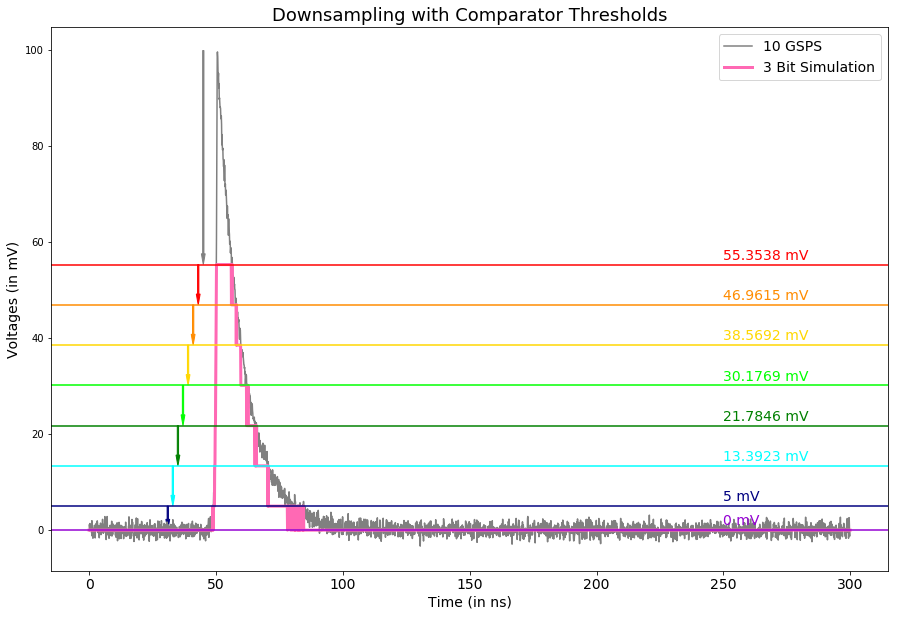

In [13]:
display(Image(filename='downsampling_w_thresholds.png', embed=True))

In [ ]:
"""
thresholded takes the original finely sampled data and downsamples it in voltage based on the
thresholds determined in the cell above

takes: some form of data dictionary, the downsampling in voltages thresholds, the key of the event, i (amount of downsampling in voltage thresholds + 1)
returns: the downsampled in voltage pulse for that particular event
"""
def thresholded(data, downsampled_thres, key, i):
    #we just want the voltages of the pulse not the time (the times are already downsampled at this point)
    pulse = np.array(data[str(key)]['Voltages'])
    for ii in range(0, i+1):
        #if the voltage value is less than the noise threshold we want the downsampled in voltage pulse to be equal to 0
        if ii == 0:
            pulse[:] = [x if x >= downsampled_thres[ii] else 0 for x in pulse]
        #if the voltage value is equal to zero (from above) or greater than the second downsample threshold make no change
        #otherwise set the voltage value equal to the noise threshold
        if ii == 1:
            pulse[:] = [x if (x == 0 or x > downsampled_thres[ii]) else downsampled_thres[ii - 1] for x in pulse]
        #if we are anywhere inbetween the 2nd threshold and the last thresholded
        #if the voltage is less than the downsampled threshold just implemented and greater than the final threshold, make no change
        #otherwise set the voltages between that range to the downsampled threshold
        if ii != i and ii != 1 and ii != 0 and ii != len(downsampled_thres):
            pulse[:] = [x if (x < downsampled_thres[ii-1] or x >= downsampled_thres[ii]) else downsampled_thres[ii-1] for x in pulse]
        #finally if the values are less then the last downsampled thresold dont make any changes
        #otherwise set the values greater than the last downsampled threshold to the value of the last downsampled threshold
        if ii == i:
            pulse[:] = [x if x < downsampled_thres[len(downsampled_thres)-1] else downsampled_thres[len(downsampled_thres) - 1] for x in pulse]

    return pulse

"""
thres2df concats the downsampled in time times for the pulse and the downsampled in voltage pulse and returns it as a dataframe

takes: some form of data dictionary, the downsamping in voltage thresholds, the key of the event, i (the amount of downsamping in voltage thresholds)
returns: a downsampled in time and voltge pulse dataframe for the particular event
"""
def thres2df(diction, downsampled_thres, key, i):
    #initialize the df
    temp1 = pd.DataFrame([])

    #create the downsampled in voltage pulse using thresholded
    temp = thresholded(diction, downsampled_thres, key, i)
    #fill the initialized dataframe with the returned voltages
    temp1 = pd.DataFrame(temp)
    #concat the downsampled in time and downsampled in voltage dfs
    temp1 = pd.concat([diction[str(key)]['times'].rename('times'), temp1], axis = 1)
    #set the names of the columns so it's easier to navigate later
    temp1.columns = ['times', 'Voltages']

    return temp1

<p>Use the above functions to create the downsampled in voltage and time events.  This is basically just a straight forward function call.  If you don't understand what any of the above code is doing, feel free to shoot me an email and ask, just make sure you include the lines you are confused about!</p>

In [ ]:
#-----this saves all the data downsampled in time and voltage in respective dictionaries ------------

#downsample the data and find the max downsampling threshold it crosses for the calibration data
thresholded_data_ch3, thresholded_data_nano_ch3, thresholded_data_pico_ch3 = (OrderedDict() for i in range(3))
thresholded_data_ch4, thresholded_data_nano_ch4, thresholded_data_pico_ch4 = (OrderedDict() for i in range(3))

i = len(downsampled_thres)

for key, value in ori_ch3.items():

    #downsample original data in voltage + save in dict
    thresholded_data_ch3[str(key)] = 
    thresholded_data_ch4[str(key)] = 

    #downsample 500ps data in voltage and save in dict
    thresholded_data_pico_ch3[str(key)] = 
    thresholded_data_pico_ch4[str(key)] = 

    #downsample 1 ns in voltage + save in dict
    thresholded_data_nano_ch3[str(key)] = 
    thresholded_data_nano_ch4[str(key)] = 

#-----this is the end of saving all the data downsampled in time and voltage it in respective dictionaries ------------

<p>Now we want to create our filter.  The following code is something that Kurtis wrote the bulk of and I manipluated in order to make it do what I wanted it to do.  The idea here is that a SiPM event can be easily simulated by two exponential equations with different taus. A small tau for the leading edge (because the rise of the event is fast) and a larger tau for the falling edge (because the fall of the event is slow).  If you haven't plotted one of the SiPM events yet, I would highly recommend trying it so you can understand what I mean. </p>

<p>We want our filter to mimic our events closely, so I have picked the following tau's because they fit our data best.  However, if you want to see how changing those numbers changes the results of filtering feel free to go back and play with this part of the tutorial after running through it once!</p>

In [ ]:
#-----this is where we generate the filter template for channel 3------------------
%matplotlib inline
import random
import math

# Time of the pulse peak
pulseTime = 0

# Time constants in nanoseconds
leadingEdgeTau = 2.0
fallingEdgeTau = 20.0

# Noise level for Gaussian noise in mV
noiseSigma = 0

# Sampling rate in ns (GHz)
sampleRate = 1.0001
sampleStep = 1 / sampleRate
# Time to start and stop waveform record
startTime = ori_ch3[str(0)].times.iloc[0]
stopTime = ori_ch3[str(0)].times.iloc[len(ori_ch3[str(0)])-1]

# Generate a random offset for all the pulses
pulseTime = pulseTime
startTime = startTime
stopTime  = stopTime

amp = 3

sampleData = []
sampleTime = []
    
times = np.arange(startTime, stopTime, sampleStep)

# Generate one pulse at time pulseTime
for timeNow in times:
    sampleTime.append(timeNow);
    if timeNow < pulseTime:
        #leading edge eq
        value = amp * math.exp( (timeNow - pulseTime) / leadingEdgeTau )
    else:
        #falling edge eq
        value = amp * math.exp( - (timeNow - pulseTime) / fallingEdgeTau )
    #we aren't adding any noise, but for the sake of clarity this is how we usually add it
    value += random.gauss(0,noiseSigma)
    sampleData.append(value)
    
#a simple plot to show the filter compared to the actual data
key = 0
plt.plot(ori_ch3[str(key)].times, ori_ch3[str(key)].Voltages)
plt.plot(times, sampleData)
plt.title('Filter Example')
plt.xlabel('Time (in ns)')
plt.ylabel('Voltage (in mV)')

print('Does {} match {}?  If not try changing the sampleRate above.'.format(len(times), len(ori_ch3[str(0)].times)))
#-----this is the end of where we generate the filter template for channel 3------------

<p>The filter also needs to be downsampled in voltage so it is a 3-bit filter.  Here we do a mini version of what is done to all the events a few cells above.  By the end of this cell we have a 3-bit filter for our channel 3 data set!</p>

In [ ]:
#the minimum and maximum 'voltage' values
maximum = 3
minimum = 0

#creating the comparator thresholds
three_bit = []
three_bit.append(minimum)
increment = float(maximum-minimum)/4

for value in range(0,2):
    minimum += increment
    three_bit.append(minimum)
three_bit.append(maximum)

#print the thresholds
print(three_bit)

i = len(three_bit)

#we just want the voltages of the pulse not the time (the times are already downsampled at this point)
pulse_ch3 = np.array(sampleData)
for ii in range(0, i+1):
    #if the voltage value is less than the noise threshold we want the downsampled in voltage pulse to be equal to 0
    if ii == 0:
        pulse_ch3[:] = [x if x >= three_bit[ii] else 0 for x in pulse_ch3]
    #if the voltage value is equal to zero (from above) or greater than the second downsample threshold make no change
    #otherwise set the voltage value equal to the noise threshold
    if ii == 1:
        pulse_ch3[:] = [x if (x == 0 or x > three_bit[ii]) else three_bit[ii - 1] for x in pulse_ch3]
    #if we are anywhere inbetween the 2nd threshold and the last thresholded
    #if the voltage is less than the downsampled threshold just implemented and greater than the final threshold, make no change
    #otherwise set the voltages between that range to the downsampled threshold
    if ii != i and ii != 1 and ii != 0 and ii != len(three_bit):
        pulse_ch3[:] = [x if (x < three_bit[ii-1] or x >= three_bit[ii]) else three_bit[ii-1] for x in pulse_ch3]
    #finally if the values are less then the last downsampled thresold dont make any changes
    #otherwise set the values greater than the last downsampled threshold to the value of the last downsampled threshold
    if ii == i:
        pulse_ch3[:] = [x if x < three_bit[len(three_bit)-1] else three_bit[len(three_bit) - 1] for x in pulse_ch3]
        
#plot the 3-bit filter!    
plt.plot(times, pulse_ch3)
plt.xlabel('Time (in ns)')
plt.ylabel('Voltages (in mV)')
plt.title('Filter Example')
plt.show()
    
#also remember we need to create 3 bit filters for both 2 GSPS and the 1 GSPS data too, otherwise our response will be wrong
average_normalized_pico_ch3 = pulse_ch3[0:len(pulse_ch3):5]
average_normalized_nano_ch3 = pulse_ch3[0:len(pulse_ch3):10]

<p>Now we walk through the exact same process to create the 3-bit filter for channel 4.</p>

In [ ]:
#-----this is where we generate the filter template------------------
# Time of the pulse peak
pulseTime = 0

# Time constants in nanoseconds
leadingEdgeTau = 2.0
fallingEdgeTau = 20.0

# Noise level for Gaussian noise in mV
noiseSigma = 0

# Sampling rate in ns (GHz)
sampleRate = 1.0001
sampleStep = 1 / sampleRate
# Time to start and stop waveform record
startTime = ori_ch4[str(0)].times.iloc[0]
stopTime = ori_ch4[str(0)].times.iloc[len(ori_ch4[str(0)])-1]

# Generate a random offset for all the pulses
pulseTime = pulseTime
startTime = startTime
stopTime  = stopTime

amp = 3

sampleData = []
sampleTime = []
    
times = np.arange(startTime, stopTime, sampleStep)

# Generate one pulse at time pulseTime
for timeNow in times:
    sampleTime.append(timeNow);
    if timeNow < pulseTime:
        value = amp * math.exp( (timeNow - pulseTime) / leadingEdgeTau )
    else:
        value = amp * math.exp( - (timeNow - pulseTime) / fallingEdgeTau )
    value += random.gauss(0,noiseSigma)
    sampleData.append(value)
    
key = 0
plt.plot(ori_ch4[str(key)].times, ori_ch4[str(key)].Voltages, label = 'event')
plt.plot(times, sampleData, label = 'filter')
plt.title('Filter Example')
plt.xlabel('Time (in ns)')
plt.ylabel('Voltage (in mV)')

print('Does {} match {}?  If not try changing the sampleRate above.'.format(len(times), len(ori_ch4[str(0)].times)))
#-----this is the end of where we generate the filter template------------

maximum = 3
minimum = 0

three_bit = []
three_bit.append(minimum)
increment = float(maximum-minimum)/4

for value in range(0,2):
    minimum += increment
    three_bit.append(minimum)
three_bit.append(maximum)

print(three_bit)

i = len(three_bit)


#we just want the voltages of the pulse not the time (the times are already downsampled at this point)
pulse_ch4 = np.array(sampleData)
for ii in range(0, i+1):
    #if the voltage value is less than the noise threshold we want the downsampled in voltage pulse to be equal to 0
    if ii == 0:
        pulse_ch4[:] = [x if x >= three_bit[ii] else 0 for x in pulse_ch4]
    #if the voltage value is equal to zero (from above) or greater than the second downsample threshold make no change
    #otherwise set the voltage value equal to the noise threshold
    if ii == 1:
        pulse_ch4[:] = [x if (x == 0 or x > three_bit[ii]) else three_bit[ii - 1] for x in pulse_ch4]
    #if we are anywhere inbetween the 2nd threshold and the last thresholded
    #if the voltage is less than the downsampled threshold just implemented and greater than the final threshold, make no change
    #otherwise set the voltages between that range to the downsampled threshold
    if ii != i and ii != 1 and ii != 0 and ii != len(three_bit):
        pulse_ch4[:] = [x if (x < three_bit[ii-1] or x >= three_bit[ii]) else three_bit[ii-1] for x in pulse_ch4]
    #finally if the values are less then the last downsampled thresold dont make any changes
    #otherwise set the values greater than the last downsampled threshold to the value of the last downsampled threshold
    if ii == i:
        pulse_ch4[:] = [x if x < three_bit[len(three_bit)-1] else three_bit[len(three_bit) - 1] for x in pulse_ch4]
        
plt.plot(times, pulse_ch4, label = '3 bit filter')
plt.xlabel('Time (in ns)')
plt.ylabel('Voltages (in mV)')
plt.title('Filter Example')
plt.legend()
plt.show()
    
average_normalized_pico_ch4 = pulse_ch4[0:len(pulse_ch4):5]
average_normalized_nano_ch4 = pulse_ch4[0:len(pulse_ch4):10]

<p>Here is the point where a few different things can happen.  The filter that I sent you originally only has 7 points, these filters have more than that.  A filter doesn't have to be the same length as the dataset in order to filter the data successfully.  Kurtis had me try out different length filters to see if any had good response.  Ideally, we would use the filter with the lowest amount of points possible that was still able to generate a a good response (which is the filter I sent you). I will put a few cells at the end of the notebook if you are interested in playing with filters of different lengths and the response they give. For the sake of this tutorial, we will just use a filter that has the same length as each of the events.</p>

<p>One of the simplest parts of this algorithm is actually filtering each event.  That is thanks to Scipy which is an amazing package that holds all these wonderous functions that make our lives easier. In particular, I'd like to point out all of the functions Scipy offers for <a href = "https://docs.scipy.org/doc/scipy/reference/signal.html">signal processing</a>.  I would recommend taking a look through these.  We are interested in the function signal.correlate().  The docs for this function can be found <a href = "https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate.html#scipy.signal.correlate">here</a>.</p>

<p>Below I have the basics outlined for our filtering function; however, I have removed the interior of the function so you can write it.</p>

In [ ]:
#---- this is the function that does the filtering------
from scipy import signal
def filtered(h, pulse):
    #first we want to corelate the signals
    #remember to divide the response by len(pulse)!

    #then we want to generate a new data frame that concats the times from pulse and the response from the correlation

    #we will return the new dataframe
    return temp
#---- this is the end of the function that does the filtering

<p>Now we want to use our function to find the filter response for each event.  I've left this written for you because I think building the filtering function is more important then calling the function (which you should already be familar with from the exercise above).</p>

In [ ]:
#---- organizing the filtered data ------------
filtered_ori_ch3, filtered_pico_ch3, filtered_nano_ch3 = (OrderedDict() for i in range(3))

for key, values in ori_ch3.items():
    filtered_ori_ch3[str(key)] = filtered(pulse_ch3, ori_ch3[str(key)])
    filtered_pico_ch3[str(key)] = filtered(average_normalized_pico_ch3, thresholded_data_pico_ch3[str(key)])
    filtered_nano_ch3[str(key)] = filtered(average_normalized_nano_ch3, thresholded_data_nano_ch3[str(key)])
#---- the end of organing the filtered data ----------

In [ ]:
#---- organizing the filtered data ------------
filtered_ori_ch4, filtered_pico_ch4, filtered_nano_ch4 = (OrderedDict() for i in range(3))

for key, values in ori_ch4.items():
    filtered_ori_ch4[str(key)] = filtered(pulse_ch4, ori_ch4[str(key)])
    filtered_pico_ch4[str(key)] = filtered(average_normalized_pico_ch4, thresholded_data_pico_ch4[str(key)])
    filtered_nano_ch4[str(key)] = filtered(average_normalized_nano_ch4, thresholded_data_nano_ch4[str(key)])
#---- the end of organing the filtered data ----------

<p>Now we can plot the event response for each sampling rate!</p>

In [ ]:
#this is just a fancy plotting package that I like
import seaborn as sns
sns.set_style('whitegrid')

#select the number of the event you want to look at
key = 4
plt.figure(figsize = (15, 15))
#this plots the filter response for the 10 GSPS data
ax = plt.subplot(311)
ax.plot(filtered_ori_ch3[str(key)].times, filtered_ori_ch3[str(key)].Voltages, 'r')
ax.set_title('Original Data Response')

#the 2 GSPS data
ax2 = plt.subplot(312)
ax2.plot(filtered_pico_ch3[str(key)].times, filtered_pico_ch3[str(key)].Voltages, color = 'green')
ax2.set_title('500ps Downsampled Data Response')
ax2.set_ylabel('Voltage (in mV)')

#the 1 GSPS data
ax3 = plt.subplot(313)
ax3.plot(filtered_nano_ch3[str(key)].times, filtered_nano_ch3[str(key)].Voltages, 'b')
ax3.set_xlabel('Time (in ns)')
ax3.set_title('1ns Downsampled Data Response')

In [ ]:
#select the number of the event you want to look at
key = 4
plt.figure(figsize = (15, 15))
#this plots the filter response for the 10 GSPS data
ax = plt.subplot(311)
ax.plot(filtered_ori_ch4[str(key)].times, filtered_ori_ch4[str(key)].Voltages, 'r')
ax.set_title('Original Data Response')

#for the 2 GSPS data
ax2 = plt.subplot(312)
ax2.plot(filtered_pico_ch4[str(key)].times, filtered_pico_ch4[str(key)].Voltages, color = 'green')
ax2.set_title('500ps Downsampled Data Response')
ax2.set_ylabel('Voltage (in mV)')

#for the 1 GSPS data
ax3 = plt.subplot(313)
ax3.plot(filtered_nano_ch4[str(key)].times, filtered_nano_ch4[str(key)].Voltages, 'b')
ax3.set_xlabel('Time (in ns)')
ax3.set_title('1ns Downsampled Data Response')

<p>Now that we have all the data we want, we should sort it in a way that makes it easy to pick out interesting trends.  Usually trends arise based on the downsampling threshold that the event crossed, so I elect to sort the data that way.</p>

<p>Another important thing we look at in the following functions are the relationship between the filter response peak and time vs. the actually maximum voltage and time of max voltage for each event.  This is how we calibrate the filter reponse to actually mean something. By creating these fits we get coefficents for a polynomial which we can easily implement in the FPGA (or in a NN) to find the actual parameters for a SiPM event given its filter response.  As with all datasets, it's important to have a larger amount of events so more amplitudes and times can be included, that way we don't have to extrapolate far beyond the limits of our simulated data.</p>

<p>Again, I will give you these functions because the organizing of data isn't terribly important for you to be bothered with. However, you should understand what these functions are trying to do. </p>

In [ ]:
'''
findpoly finds the polynomial coefficents so we can estimate the maximum voltage value based on the maximum filter response

takes:great['max_vals'], the filter response dict, and the last time of the first event.
returns:the polynomial coefficents for a 4th order fit
'''
def findpoly(y, flit, end):
    max_value = pd.Series([])
    last = pd.Series([])
    a = 0
    for event, values in flit.items():
        max_value[a] = flit[str(event)]['Voltages'].max()
        last[a] = flit[str(event)]['times'].loc[len(flit[str(event)])-1]
        a += 1
   
    temp = pd.DataFrame([max_value.rename('recovered'), y.rename('maximum'), last.rename('last')])
    temp = temp.T
    temp = temp.sort_values(by=['recovered'], ascending = False)
    #this is a fail safe so if there are any events that hit the limit of the oscilloscope they are removed
    temp = temp.query('maximum < 44')
    #this is another fail safe so if there are any akward events that trigger late in time they can be removed
    temp = temp[temp['last'] >= end]
    
    #generate the polynomial
    z = np.polyfit(temp['recovered'], temp['maximum'], 4)
    #get the polynomial coefficents so we can fit things later
    p_peak = np.poly1d(z)
    
    
    return p_peak
'''
sorter sorts the information we are interested in based on maximum voltage threshold crossed by each event and it only
returns the events for the threshold of interest

takes: an original threshold_data_dict, the downsampling threshold in question, great, the filter response dict, the polynomial coeffs,
and the last time recorded for event 0
returns: a pd.Series of maximum values, event indexes, maximum peak response, and estimated peak response using the poly coeffs
'''    
def sorter(diction, threshold, great, peak, p_peak, end):
    y, index, max_value, adj, max_times, adj_time, x = (pd.Series([]) for i in range(7))
    a = 0
    for event, values in diction.items():
        #the data is organized based on threshold
        if diction[str(event)]['Voltages'].max() == threshold and peak[str(event)]['Voltages'].max() != 0 and diction[str(event)]['times'].iloc[len(diction[str(event)])-1] >= end - 10:
            y[a] = great['max_vals'].loc[int(event)]
            index[a] = int(event)
            max_value[a] = peak[str(event)]['Voltages'].max()
            a += 1
            
    #try to estimate the voltage peak based on the response peak
    if len(max_value) != 0:        
        adj = p_peak(max_value)

    return y, index, max_value, adj
'''
organizer utilizes sorter to sort the data in each dictionary based on the highest voltage threshold it crosses
it then produces things such as voltage residuals and timing residuals and packages it in a nice dataframe which it returns

takes: an original threshold_data_dict, the value of the downsampling threshold, great, the filter response dictionary, the corresponding polynomial coeffs,
and the last time recorded for event 0
returns: organized dataframe
'''

def organizer(diction, threshold, great, peak, p_peak, end):

    #find all the seperate series
    y, index, max_value, adj = sorter(diction, threshold, great, peak, p_peak, end)

    #we need to find some residuals to see how well the algoritm worked
    residuals_max = np.subtract(y, max_value)
    adjusted = pd.Series(adj)
    residuals_adj = np.subtract(y, adj)
    
    #concat all the series into on dataframe
    temp = pd.concat([index.rename('index'), y.rename('true max'), max_value.rename('recovered_peak'), residuals_max.rename('peak residuals'), adjusted.rename('adjusted peak'), residuals_adj.rename('adjusted residuals')], axis = 1)
    #set the index of the dataframe to the number of the events
    temp = temp.set_index('index')


    return temp


amp_pico_ch3, amp_nano_ch3  = (OrderedDict([]) for i in range(2))
#find the polynomial coefficents for the 2 GSPS and the 1 GSPS datasets--channel 3
p_peak_p_ch3 = findpoly(great_ch3['max_vals'], filtered_pico_ch3, five_hundred_pico_ch3[str(0)].times.iloc[len(five_hundred_pico_ch3[str(0)])-1])
p_peak_n_ch3 = findpoly(great_ch3['max_vals'], filtered_nano_ch3, one_nano_ch3[str(0)].times.iloc[len(one_nano_ch3[str(0)])-1])
#again, we sort data based on the highest voltage threshold that is crossed
for value in range(0, len(downsampled_thres)):
    #find the organized dataframe
    temp = organizer(thresholded_data_pico_ch3, downsampled_thres[value], great_ch3, filtered_pico_ch3, p_peak_p_ch3, five_hundred_pico_ch3[str(0)].times.iloc[len(five_hundred_pico_ch3[str(0)])-1])
    print(len(temp))
    #we don't want to save the dataframe if it has no data in it
    if len(temp) > 0:
        amp_pico_ch3[str(downsampled_thres[value])] = temp
    
    #find the organized dataframe
    temp = organizer(thresholded_data_nano_ch3, downsampled_thres[value], great_ch3, filtered_nano_ch3, p_peak_n_ch3, one_nano_ch3[str(0)].times.iloc[len(one_nano_ch3[str(0)])-1])
    #don't save the dataframe if it has no data in it
    if len(temp) > 0:
        amp_nano_ch3[str(downsampled_thres[value])] = temp
        
amp_pico_ch4, amp_nano_ch4  = (OrderedDict([]) for i in range(2))
#find the polynomial coefficents for the 2 GSPS and the 1 GSPS datasets--channel 4
p_peak_p_ch4 = findpoly(great_ch4['max_vals'], filtered_pico_ch4, five_hundred_pico_ch4[str(0)].times.iloc[len(five_hundred_pico_ch4[str(0)])-1])
p_peak_n_ch4 = findpoly(great_ch4['max_vals'], filtered_nano_ch4, one_nano_ch4[str(0)].times.iloc[len(one_nano_ch4[str(0)])-1])
#again, we sort data based on the highest voltage threshold that is crossed
for value in range(0, len(downsampled_thres)):
    #find the organized dataframe
    temp = organizer(thresholded_data_pico_ch4, downsampled_thres[value], great_ch4, filtered_pico_ch4, p_peak_p_ch4, five_hundred_pico_ch4[str(0)].times.iloc[len(five_hundred_pico_ch4[str(0)])-1])
    print(len(temp))
    #we dont want to save the dataframe if it has no data in it
    if len(temp) > 0:
        amp_pico_ch4[str(downsampled_thres[value])] = temp
    
    #find the organized dataframe
    temp = organizer(thresholded_data_nano_ch4, downsampled_thres[value], great_ch4, filtered_nano_ch4, p_peak_n_ch4, one_nano_ch4[str(0)].times.iloc[len(one_nano_ch4[str(0)])-1])
    #we dont want to save the dataframe if it has no data in it
    if len(temp) > 0:
        amp_nano_ch4[str(downsampled_thres[value])] = temp

<p>I'm not going to comment the following cell as well because it does the same as above, but for the 10 GSPS data.  Because the data is finer sampled in time the order can generally be dropped for the polynomial from an order 4 to order 1.</p>

In [ ]:
def findpoly_ori(y, flit, end):
    max_value = pd.Series([])
    last = pd.Series([])
    a = 0
    for event, values in flit.items():
        max_value[a] = flit[str(event)]['Voltages'].max()
        last[a] = flit[str(event)]['times'].loc[len(flit[str(event)])-1]
        a += 1
        
    end = end - 10
   
    temp = pd.DataFrame([max_value.rename('recovered'), y.rename('maximum'), last.rename('last')])
    temp = temp.T
    temp = temp.sort_values(by=['recovered'], ascending = False)
    temp = temp.query('maximum < 44')
    temp = temp[temp['last'] >= end]
    
    z = np.polyfit(temp['recovered'], temp['maximum'], 1)
    p_peak = np.poly1d(z)

    
    return p_peak

def sorter_ori(diction, threshold, great, peak, p_peak, end):
    y, index, max_value, adj, max_times, adj_time, x = (pd.Series([]) for i in range(7))
    a = 0
    for event, values in diction.items():
        #the data is organized based on threshold
        if diction[str(event)]['Voltages'].max() == threshold and peak[str(event)]['Voltages'].max() > 10**-14 and diction[str(event)]['times'].iloc[len(diction[str(event)])-1] >= end - 10:
            y[a] = great['max_vals'].loc[int(event)]
            index[a] = int(event)
            max_value[a] = peak[str(event)]['Voltages'].max()
            a += 1
            
    if len(max_value) != 0:        
        adj = p_peak(max_value)
        #plt.plot(max_value, p_peak(max_value), 'bo')
        #plt.show()

    return y, index, max_value, adj

def organizer_ori(diction, threshold, great, peak, p_peak, end):

    #find all the seperate series
    y, index, max_value, adj = sorter_ori(diction, threshold, great, peak, p_peak, end)

    #we need to find some residuals to see how well the algoritm worked
    residuals_max = np.subtract(y, max_value)
    
    adjusted = pd.Series(adj)
    residuals_adj = np.subtract(y, adj)
    
    
    #concat all the series into on dataframe
    temp = pd.concat([index.rename('index'), y.rename('true max'), max_value.rename('recovered_peak'), residuals_max.rename('peak residuals'), adjusted.rename('adjusted peak'), residuals_adj.rename('adjusted residuals')], axis = 1)
    #set the index of the dataframe to the number of the events
    temp = temp.set_index('index')


    return temp

#crap = OrderedDict()
p_peak_ch3 = findpoly_ori(great_ch3['max_vals'], filtered_ori_ch3, ori_ch3[str(0)].times.iloc[len(ori_ch3[str(0)])-1])
amp_ori_ch3 = OrderedDict()
for value in range(0, len(downsampled_thres)):
    #find the organized dataframe
    temp = organizer_ori(thresholded_data_ch3, downsampled_thres[value], great_ch3, filtered_ori_ch3, p_peak_ch3, ori_ch3[str(0)].times.iloc[len(ori_ch3[str(0)])-1])
    #print downsampled_thres[value], downsampled_thres[value + 1], len(temp)
    print(len(temp))
    if len(temp) > 0:
        amp_ori_ch3[str(downsampled_thres[value])] = temp
        
p_peak_ch4 = findpoly_ori(great_ch4['max_vals'], filtered_ori_ch4, ori_ch4[str(0)].times.iloc[len(ori_ch4[str(0)])-1])
amp_ori_ch4 = OrderedDict()
for value in range(0, len(downsampled_thres)):
    #find the organized dataframe
    temp = organizer_ori(thresholded_data_ch4, downsampled_thres[value], great_ch4, filtered_ori_ch4, p_peak_ch4, ori_ch4[str(0)].times.iloc[len(ori_ch4[str(0)])-1])
    #print downsampled_thres[value], downsampled_thres[value + 1], len(temp)
    print(len(temp))
    if len(temp) > 0:
        amp_ori_ch4[str(downsampled_thres[value])] = temp

<p>The following cell plots the relationship between the maximum filter response peak and the real maximum voltage of each event.  The plotted lines are the polynomials generated above.  Do you notice any trends about the data?  Why do you think there are these trends?</p>

In [ ]:
plt.figure(figsize = (10, 15))
ax = plt.subplot(311)

max_vals = pd.Series([])
recov = pd.Series([])
a = 0
for key in amp_ori_ch3:
    for idx in amp_ori_ch3[str(key)].index:
        ax.plot(amp_ori_ch3[str(key)]['recovered_peak'].loc[idx], amp_ori_ch3[str(key)]['true max'].loc[idx], 'ro')
        max_vals[a] = amp_ori_ch3[str(key)]['true max'].loc[idx]
        recov[a] = amp_ori_ch3[str(key)]['recovered_peak'].loc[idx]
        a+=1

#ax.xlabel('recovered peak')
#ax.ylabel('actual peak')
temp = pd.DataFrame([pd.Series(max_vals).rename('max'), pd.Series(recov).rename('recovered')])
temp = temp.T
temp = temp.sort_values(by=['recovered'], ascending = False)
z = np.polyfit(temp['recovered'], temp['max'], 1)
p = np.poly1d(z)
ax.plot(temp['recovered'], p(temp['recovered']), 'k-')
ax.set_title('Peak Comparison Original Data-Channel 3')

ax2 = plt.subplot(312)

max_vals = pd.Series([])
recov = pd.Series([])
a = 0
for key in amp_pico_ch3:
    for idx in amp_pico_ch3[str(key)].index:
        ax2.plot(amp_pico_ch3[str(key)]['recovered_peak'].loc[idx], amp_pico_ch3[str(key)]['true max'].loc[idx], 'ro')
        max_vals[a] = amp_pico_ch3[str(key)]['true max'].loc[idx]
        recov[a] = amp_pico_ch3[str(key)]['recovered_peak'].loc[idx]
        a += 1

temp = pd.DataFrame([pd.Series(max_vals).rename('max'), pd.Series(recov).rename('recovered')])
temp = temp.T
temp = temp.sort_values(by=['recovered'], ascending = False)
z = np.polyfit(temp['recovered'], temp['max'], 4)
p = np.poly1d(z)
ax2.plot(temp['recovered'], p(temp['recovered']), 'k-')
ax2.set_title('Peak Comparison 500ps Data-Channel 3')
ax2.set_ylabel('Actual Peak')

ax3 = plt.subplot(313)

max_vals = pd.Series([])
recov = pd.Series([])
a = 0
for key in amp_nano_ch3:
    #print len(amp_nano[amp_nano.keys()[value]])
    for idx in amp_nano_ch3[str(key)].index:
        ax3.plot(amp_nano_ch3[str(key)]['recovered_peak'].loc[idx], amp_nano_ch3[str(key)]['true max'].loc[idx], 'ro')
        max_vals[a] = amp_nano_ch3[str(key)]['true max'].loc[idx]
        recov[a] = amp_nano_ch3[str(key)]['recovered_peak'].loc[idx]
        a += 1
        
temp = pd.DataFrame([pd.Series(max_vals).rename('max'), pd.Series(recov).rename('recovered')])
temp = temp.T
temp = temp.sort_values(by=['recovered'], ascending = False)
z = np.polyfit(temp['recovered'], temp['max'], 4)
p = np.poly1d(z)
ax3.plot(temp['recovered'], p(temp['recovered']), 'k-')
ax3.set_title('Peak Comparison 1ns Data-Channel 3')
ax3.set_xlabel('Response Peak')

In [ ]:
plt.figure(figsize = (10, 15))
ax = plt.subplot(311)

max_vals = pd.Series([])
recov = pd.Series([])
a = 0
for key in amp_ori_ch4:
    for idx in amp_ori_ch4[str(key)].index:
        ax.plot(amp_ori_ch4[str(key)]['recovered_peak'].loc[idx], amp_ori_ch4[str(key)]['true max'].loc[idx], 'ro')
        max_vals[a] = amp_ori_ch4[str(key)]['true max'].loc[idx]
        recov[a] = amp_ori_ch4[str(key)]['recovered_peak'].loc[idx]
        a+=1

#ax.xlabel('recovered peak')
#ax.ylabel('actual peak')
temp = pd.DataFrame([pd.Series(max_vals).rename('max'), pd.Series(recov).rename('recovered')])
temp = temp.T
temp = temp.sort_values(by=['recovered'], ascending = False)
z = np.polyfit(temp['recovered'], temp['max'], 1)
p = np.poly1d(z)
ax.plot(temp['recovered'], p(temp['recovered']), 'k-')
ax.set_title('Peak Comparison Original Data-Channel 4')

ax2 = plt.subplot(312)

max_vals = pd.Series([])
recov = pd.Series([])
a = 0
for key in amp_pico_ch4:
    for idx in amp_pico_ch4[str(key)].index:
        ax2.plot(amp_pico_ch4[str(key)]['recovered_peak'].loc[idx], amp_pico_ch4[str(key)]['true max'].loc[idx], 'ro')
        max_vals[a] = amp_pico_ch4[str(key)]['true max'].loc[idx]
        recov[a] = amp_pico_ch4[str(key)]['recovered_peak'].loc[idx]
        a += 1

temp = pd.DataFrame([pd.Series(max_vals).rename('max'), pd.Series(recov).rename('recovered')])
temp = temp.T
temp = temp.sort_values(by=['recovered'], ascending = False)
z = np.polyfit(temp['recovered'], temp['max'], 4)
p = np.poly1d(z)
ax2.plot(temp['recovered'], p(temp['recovered']), 'k-')
ax2.set_title('Peak Comparison 500ps Data-Channel 4')
ax2.set_ylabel('Actual Peak')

ax3 = plt.subplot(313)

max_vals = pd.Series([])
recov = pd.Series([])
a = 0
for key in amp_nano_ch4:
    #print len(amp_nano[amp_nano.keys()[value]])
    for idx in amp_nano_ch4[str(key)].index:
        ax3.plot(amp_nano_ch4[str(key)]['recovered_peak'].loc[idx], amp_nano_ch4[str(key)]['true max'].loc[idx], 'ro')
        max_vals[a] = amp_nano_ch4[str(key)]['true max'].loc[idx]
        recov[a] = amp_nano_ch4[str(key)]['recovered_peak'].loc[idx]
        a += 1
        
temp = pd.DataFrame([pd.Series(max_vals).rename('max'), pd.Series(recov).rename('recovered')])
temp = temp.T
temp = temp.sort_values(by=['recovered'], ascending = False)
z = np.polyfit(temp['recovered'], temp['max'], 4)
p = np.poly1d(z)
ax3.plot(temp['recovered'], p(temp['recovered']), 'k-')
ax3.set_title('Peak Comparison 1ns Data-Channel 4')
ax3.set_xlabel('Response Peak')

<p>Now lets look at how well our algorithm performed using these polynomial fit relationships.  Each graph below will be a histogram.  The top row will be voltage residual (ie. estimated voltage - actual voltage) divided by each threshold, the second row will be for the entire data set.  The title of the graph indicates which sampling rate each graph is for.  Again, do you notice any trends?</p>

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')

len_subplots = len(range(0, len(amp_pico_ch3.keys())))
fig = plt.figure(figsize = (35, 40))
fig.patch.set_facecolor('white')
plt.figtext(0.5,0.90,"Event Peak Residuals: 500 ps Sampling-Channel 3", va="center", ha="center", size=20)

value = 0
for key in amp_pico_ch3:
    ax = plt.subplot(4, len_subplots, value+1)
    temp = amp_pico_ch3[str(key)]['adjusted residuals']
    ax.hist(np.array(temp), bins = 20, normed = 1, color = 'cornflowerblue')
    mean, std = norm.fit(temp)
    #print 'downsampled thres: {} \t mean: {}'.format(amp_pico.keys()[value], mean)
    xmin, xmax = temp.min(), temp.max()
    x = np.linspace(xmin, xmax, 1000)
    y = norm.pdf(x, mean, std)
    ax.plot(x, y, color = 'black', label = 'stdev: '+str(round(std,5)), lw = 2)
    ax.legend(fontsize = 16)
    ax.set_title(round(float(key), 3), fontsize = 20)
    value += 1


axes2 = plt.subplot(412)
axes2.set_title("Recovered Amplitude Residuals", fontsize = 20)
peak_residuals = amp_pico_ch3[str(list(amp_pico_ch3.keys())[0])]['adjusted residuals']
for key in amp_pico_ch3:
        peak_residuals = pd.concat([peak_residuals, amp_pico_ch3[str(key)]['adjusted residuals']])
mean, std = norm.fit(peak_residuals)
xmin, xmax = peak_residuals.min(), peak_residuals.max()
x = np.linspace(xmin, xmax, 1000)
y = norm.pdf(x, mean, std)
axes2.hist(peak_residuals, 50, normed = 1, color = 'cornflowerblue')
axes2.plot(x, y, color = 'black', ls = '-', label = 'stdev: '+str(round(std,5)))
axes2.legend(fontsize = 16)
axes2.set_xlabel('Actual Peak - Adjusted Peak', fontsize = 16)

len_subplots = len(range(0, len(amp_pico_ch4.keys())))
plt.figtext(0.5,0.50,"Event Peak Residuals: 500 ps Sampling-Channel 4", va="center", ha="center", size=20)

value = 0
for key in amp_pico_ch4:
    ax = plt.subplot(4, len_subplots, value+13)
    temp = amp_pico_ch4[str(key)]['adjusted residuals']
    ax.hist(np.array(temp), bins = 20, normed = 1, color = 'hotpink')
    mean, std = norm.fit(temp)
    #print 'downsampled thres: {} \t mean: {}'.format(amp_pico.keys()[value], mean)
    xmin, xmax = temp.min(), temp.max()
    x = np.linspace(xmin, xmax, 1000)
    y = norm.pdf(x, mean, std)
    ax.plot(x, y, color = 'black', label = 'stdev: '+str(round(std,5)), lw = 2)
    ax.legend(fontsize = 16)
    ax.set_title(round(float(key), 3), fontsize = 20)
    value += 1


axes2 = plt.subplot(414)
axes2.set_title("Recovered Amplitude Residuals", fontsize = 20)
peak_residuals = amp_pico_ch4[str(list(amp_pico_ch4.keys())[0])]['adjusted residuals']
for key in amp_pico_ch4:
        peak_residuals = pd.concat([peak_residuals, amp_pico_ch4[str(key)]['adjusted residuals']])
mean, std = norm.fit(peak_residuals)
xmin, xmax = peak_residuals.min(), peak_residuals.max()
x = np.linspace(xmin, xmax, 1000)
y = norm.pdf(x, mean, std)
axes2.hist(peak_residuals, 50, normed = 1, color = 'hotpink')
axes2.plot(x, y, color = 'black', ls = '-', label = 'stdev: '+str(round(std,5)))
axes2.legend(fontsize = 16)
axes2.set_xlabel('Actual Peak - Adjusted Peak', fontsize = 16)

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')

len_subplots = len(range(0, len(amp_nano_ch3.keys())))
fig = plt.figure(figsize = (35, 40))
fig.patch.set_facecolor('white')
plt.figtext(0.5,0.90,"Event Peak Residuals: 1 ns Sampling-Channel 3", va="center", ha="center", size=20)

value = 0
for key in amp_nano_ch3:
    ax = plt.subplot(4, len_subplots, value+1)
    temp = amp_nano_ch3[str(key)]['adjusted residuals']
    ax.hist(np.array(temp), bins = 20, normed = 1, color = 'cornflowerblue')
    mean, std = norm.fit(temp)
    #print 'downsampled thres: {} \t mean: {}'.format(amp_pico.keys()[value], mean)
    xmin, xmax = temp.min(), temp.max()
    x = np.linspace(xmin, xmax, 1000)
    y = norm.pdf(x, mean, std)
    ax.plot(x, y, color = 'black', label = 'stdev: '+str(round(std,5)), lw = 2)
    ax.legend(fontsize = 16)
    ax.set_title(round(float(key), 3), fontsize = 20)
    value += 1


axes2 = plt.subplot(412)
axes2.set_title("Recovered Amplitude Residuals", fontsize = 20)
peak_residuals = amp_nano_ch3[str(list(amp_nano_ch3.keys())[0])]['adjusted residuals']
for key in amp_nano_ch3:
        peak_residuals = pd.concat([peak_residuals, amp_nano_ch3[str(key)]['adjusted residuals']])
mean, std = norm.fit(peak_residuals)
xmin, xmax = peak_residuals.min(), peak_residuals.max()
x = np.linspace(xmin, xmax, 1000)
y = norm.pdf(x, mean, std)
axes2.hist(peak_residuals, 50, normed = 1, color = 'cornflowerblue')
axes2.plot(x, y, color = 'black', ls = '-', label = 'stdev: '+str(round(std,5)))
axes2.legend(fontsize = 16)
axes2.set_xlabel('Actual Peak - Adjusted Peak', fontsize = 16)

len_subplots = len(range(0, len(amp_nano_ch4.keys())))
plt.figtext(0.5,0.50,"Event Peak Residuals: 1 ns Sampling-Channel 4", va="center", ha="center", size=20)

value = 0
for key in amp_nano_ch4:
    ax = plt.subplot(4, len_subplots, value+13)
    temp = amp_nano_ch4[str(key)]['adjusted residuals']
    ax.hist(np.array(temp), bins = 20, normed = 1, color = 'hotpink')
    mean, std = norm.fit(temp)
    #print 'downsampled thres: {} \t mean: {}'.format(amp_pico.keys()[value], mean)
    xmin, xmax = temp.min(), temp.max()
    x = np.linspace(xmin, xmax, 1000)
    y = norm.pdf(x, mean, std)
    ax.plot(x, y, color = 'black', label = 'stdev: '+str(round(std,5)), lw = 2)
    ax.legend(fontsize = 16)
    ax.set_title(round(float(key), 3), fontsize = 20)
    value += 1


axes2 = plt.subplot(414)
axes2.set_title("Recovered Amplitude Residuals", fontsize = 20)
peak_residuals = amp_nano_ch4[str(list(amp_nano_ch4.keys())[0])]['adjusted residuals']
for key in amp_nano_ch4:
        peak_residuals = pd.concat([peak_residuals, amp_nano_ch4[str(key)]['adjusted residuals']])
mean, std = norm.fit(peak_residuals)
xmin, xmax = peak_residuals.min(), peak_residuals.max()
x = np.linspace(xmin, xmax, 1000)
y = norm.pdf(x, mean, std)
axes2.hist(peak_residuals, 50, normed = 1, color = 'hotpink')
axes2.plot(x, y, color = 'black', ls = '-', label = 'stdev: '+str(round(std,5)))
axes2.legend(fontsize = 16)
axes2.set_xlabel('Actual Peak - Adjusted Peak', fontsize = 16)

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')

len_subplots = len(range(0, len(amp_ori_ch3.keys())))
fig = plt.figure(figsize = (35, 40))
fig.patch.set_facecolor('white')
plt.figtext(0.5,0.90,"Event Peak Residuals: 10Gsps Timing and Original Voltage-Channel 3", va="center", ha="center", size=20)

value = 0
for key in amp_ori_ch3:
    ax = plt.subplot(4, len_subplots, value+1)
    temp = amp_ori_ch3[str(key)]['adjusted residuals']
    ax.hist(np.array(temp), bins = 20, normed = 1, color = 'cornflowerblue')
    mean, std = norm.fit(temp)
    #print 'downsampled thres: {} \t mean: {}'.format(amp_pico.keys()[value], mean)
    xmin, xmax = temp.min(), temp.max()
    x = np.linspace(xmin, xmax, 1000)
    y = norm.pdf(x, mean, std)
    ax.plot(x, y, color = 'black', label = 'stdev: '+str(round(std,5)), lw = 2)
    ax.legend(fontsize = 16)
    ax.set_title(round(float(key), 3), fontsize = 20)
    value += 1


axes2 = plt.subplot(412)
axes2.set_title("Recovered Amplitude Residuals", fontsize = 20)
peak_residuals = amp_ori_ch3[str(list(amp_ori_ch3.keys())[0])]['adjusted residuals']
for key in amp_ori_ch3:
        peak_residuals = pd.concat([peak_residuals, amp_ori_ch3[str(key)]['adjusted residuals']])
mean, std = norm.fit(peak_residuals)
xmin, xmax = peak_residuals.min(), peak_residuals.max()
x = np.linspace(xmin, xmax, 1000)
y = norm.pdf(x, mean, std)
axes2.hist(peak_residuals, 50, normed = 1, color = 'cornflowerblue')
axes2.plot(x, y, color = 'black', ls = '-', label = 'stdev: '+str(round(std,5)))
axes2.legend(fontsize = 16)
axes2.set_xlabel('Actual Peak - Adjusted Peak', fontsize = 16)

len_subplots = len(range(0, len(amp_ori_ch4.keys())))
plt.figtext(0.5,0.50,"Event Peak Residuals: 10Gsps Timing and Original Voltage-Channel 4", va="center", ha="center", size=20)

value = 0
for key in amp_ori_ch4:
    ax = plt.subplot(4, len_subplots, value+13)
    temp = amp_ori_ch4[str(key)]['adjusted residuals']
    ax.hist(np.array(temp), bins = 20, normed = 1, color = 'hotpink')
    mean, std = norm.fit(temp)
    #print 'downsampled thres: {} \t mean: {}'.format(amp_pico.keys()[value], mean)
    xmin, xmax = temp.min(), temp.max()
    x = np.linspace(xmin, xmax, 1000)
    y = norm.pdf(x, mean, std)
    ax.plot(x, y, color = 'black', label = 'stdev: '+str(round(std,5)), lw = 2)
    ax.legend(fontsize = 16)
    ax.set_title(round(float(key), 3), fontsize = 20)
    value += 1


axes2 = plt.subplot(414)
axes2.set_title("Recovered Amplitude Residuals", fontsize = 20)
peak_residuals = amp_ori_ch4[str(list(amp_ori_ch4.keys())[0])]['adjusted residuals']
for key in amp_ori_ch4:
        peak_residuals = pd.concat([peak_residuals, amp_ori_ch4[str(key)]['adjusted residuals']])
mean, std = norm.fit(peak_residuals)
xmin, xmax = peak_residuals.min(), peak_residuals.max()
x = np.linspace(xmin, xmax, 1000)
y = norm.pdf(x, mean, std)
axes2.hist(peak_residuals, 50, normed = 1, color = 'hotpink')
axes2.plot(x, y, color = 'black', ls = '-', label = 'stdev: '+str(round(std,5)))
axes2.legend(fontsize = 16)
axes2.set_xlabel('Actual Peak - Adjusted Peak', fontsize = 16)